In [2]:
import numpy as np
import matplotlib.pyplot as plt
from evaluate import load
from textwrap import wrap
from datasets import load_dataset, concatenate_datasets
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import TrainingArguments, Trainer

In [3]:
# Flickr30k датасет - состоит из 30 000 изображений, каждое из которых связано с пятью разными подписями,
# обеспечивающими точное описание основных объектов и событий. В них нет известных людей или мест.
# Демонстрирует разных сцен и ситуаций.
ds_flickr30k = load_dataset("lmms-lab/flickr30k")

ds_flickr30k

DatasetDict({
    test: Dataset({
        features: ['image', 'caption', 'sentids', 'img_id', 'filename'],
        num_rows: 31783
    })
})

In [4]:
# Функция поиска в подписях изображений упоминаний про детей, младенцев, мальчиков, девочек
def check_for_children(caption_list):
    keywords = ["child", "girl", "boy", "baby"]
    return any(
        keyword in caption.lower() for keyword in keywords for caption in caption_list
    )

In [5]:
# Бинарная разметка датасета по наличию детей
ds_flickr30k["test"] = ds_flickr30k["test"].add_column(
    "has_children",
    [check_for_children(example["caption"]) for example in ds_flickr30k["test"]],
)

# Фильтрация датасета только на детей
filter_ds_flickr30k = ds_flickr30k["test"].filter(
    lambda example: example["has_children"]
)

# Удаление лишней информации
filter_ds_flickr30k = filter_ds_flickr30k.remove_columns(
    ["sentids", "has_children", "img_id", "filename"]
)

filter_ds_flickr30k

Dataset({
    features: ['image', 'caption'],
    num_rows: 10361
})

In [6]:
# NoCaps датасет - состоит из 166 100 созданных человеком подписей, описывающих 15 100 изображений
# из проверочных и тестовых наборов Open Images.
ds_nocaps = load_dataset("lmms-lab/NoCaps")

ds_nocaps

DatasetDict({
    validation: Dataset({
        features: ['image', 'image_coco_url', 'image_date_captured', 'image_file_name', 'image_height', 'image_width', 'image_id', 'image_license', 'image_open_images_id', 'annotations_ids', 'annotations_captions'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['image', 'image_coco_url', 'image_date_captured', 'image_file_name', 'image_height', 'image_width', 'image_id', 'image_license', 'image_open_images_id', 'annotations_ids', 'annotations_captions'],
        num_rows: 10600
    })
})

In [7]:
# Бинарная разметка датасета по наличию детей
ds_nocaps["validation"] = ds_nocaps["validation"].add_column(
    "has_children",
    [
        check_for_children(example["annotations_captions"])
        for example in ds_nocaps["validation"]
    ],
)

# Фильтрация датасета только на детей
filter_ds_nocaps = ds_nocaps["validation"].filter(
    lambda example: example["has_children"]
)

# Удаление лишней информации
filter_ds_nocaps = filter_ds_nocaps.remove_columns(
    [
        "annotations_ids",
        "has_children",
        "image_open_images_id",
        "image_license",
        "image_width",
        "image_height",
        "image_date_captured",
        "image_coco_url",
        "image_file_name",
        "image_id",
    ]
)

# Переименование колонок под соответствие первому датасету
filter_ds_nocaps = filter_ds_nocaps.rename_columns({"annotations_captions": "caption"})

filter_ds_nocaps

Dataset({
    features: ['image', 'caption'],
    num_rows: 667
})

In [8]:
# Объединение дву датасетов для дообучения моделей
ds_train = concatenate_datasets([filter_ds_flickr30k, filter_ds_nocaps])

ds_train

Dataset({
    features: ['image', 'caption'],
    num_rows: 11028
})

In [9]:
def get_first_caption(example):
    example["caption"] = example["caption"][0]
    return example


ds_train = ds_train.map(get_first_caption)

In [10]:
ds_train.save_to_disk("datasets/ds_train")

Saving the dataset (0/4 shards):   0%|          | 0/11028 [00:00<?, ? examples/s]

In [11]:
from datasets import load_from_disk

ds_train = load_from_disk("datasets/ds_train")

In [12]:
ds = ds_train.train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

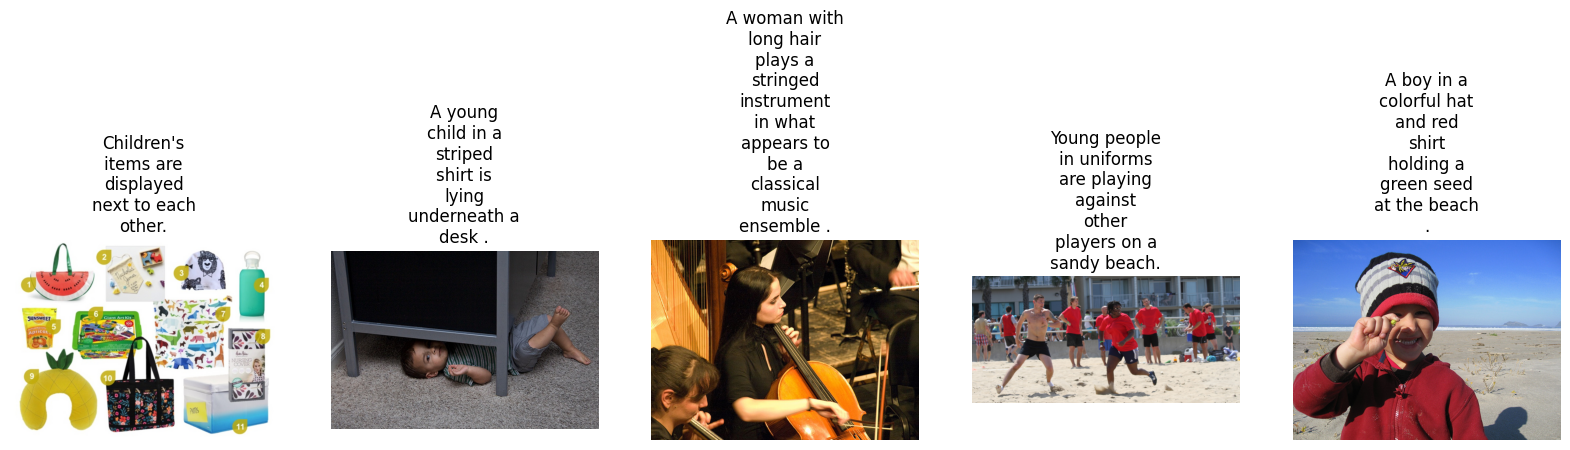

In [13]:
def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["caption"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [15]:
processor = BlipProcessor.from_pretrained("abhijit2111/Pic2Story")
model = BlipForConditionalGeneration.from_pretrained("abhijit2111/Pic2Story")

In [12]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["caption"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [13]:
wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"WER score": wer_score}

In [14]:
training_args = TrainingArguments(
    output_dir=f"Pic2Story-train",
    learning_rate=5e-5,
    num_train_epochs=2,
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [16]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: n-hilkovich. Use `wandb login --relogin` to force relogin


  0%|          | 0/310 [00:00<?, ?it/s]